# CX 4230, Spring 2016: [18] Discrete event simulation of a gas station

Recall the introduction to queueing models and discrete event simulators from the last class: [link](https://t-square.gatech.edu/access/content/group/gtc-59b8-dc03-5a67-a5f4-88b8e4d5b69a/cx4230-sp16--17-queueing.pdf). In this notebook, you will implement it.

In [1]:
DEBUG = 1
PARKING_NODE_COLOR = 'b'
EXIT_NODE_COLOR = 'r'
STREET_NODE_COLOR = 'g'

In [2]:
import types
from copy import deepcopy
from random import random, seed, gauss
from math import log

def getDirection(node):
    (x1,y1) = node.start
    (x2,y2) = node.end
    if((x2-x1) == 0):
        if(y2 > y1):
            deg = 90
        else:
            deg = 270
    elif((y2-y1) == 0):
        if(x2>x1):
            deg = 0
        else:
            deg = 180
    else:
        deg = math.atan((y2-y1)/(x2-x1)) / math.pi * 180
        if(deg < 0):
            deg += 360
        if(y2<y1 and x2<x1):
            deg += 180
        if(y2>y1 and x2<x1):
            deg -= 180
    return deg

def genRandom(l, type='exponential'):
    if(type == 'exponential'):
        return -l*log(1-random())
    elif(type == 'uniform'):
        return random()
    elif(type == 'normal'):
        return gauss(0,1)
    
def genID(N=5):
    ''.join(random.SystemRandom().choice(string.ascii_uppercase + string.digits) for _ in range(N))

#Parking, streets are all nodes.
#Attributes:
#   type: Either 0/1 0 -> street  1-> parking
#   start, end: tuple
#   capactiy: integer
#   comment: string
#   id: assigned id for easy identification
#   exit: whether this node is a designated evacuation location 
#Each node is connected to the nodes that have start as this node's start.
class Node:
    TYPE_STREET = 0
    TYPE_PARKING = 1
    def __init__(self, type, start, end, capacity, id, comment='', exit=False):
        assert(type == Node.TYPE_PARKING or type == Node.TYPE_STREET)
        self.type = type
        assert(len(start) == 2)
        self.start = start

        assert(len(end) == 2)
        self.end = end

        assert(start != end)
        assert(capacity > 0)
        self.capacity = capacity
        self.comment = comment
        self.id = id
        self.exit = exit
        self.__cars = []
        self.__children = []

    def enterCar(self, car):
        assert(self.canEnterCar())
        assert(isinstance(car, Car))
        self.__cars.append(car)
        car.setCurrentNode(self)

    def exitCar(self):
        return self.__cars.pop()
    def carCount(self):
        return len(self.__cars)
    def canEnterCar(self):
        return(self.carCount() < self.capacity)
    def setExit(self, isExit):
        self.exit = isExit
    def addChildNode(self, node):
        assert(isinstance(node, Node))
        self.__children.append(node)
    def getChildren(self):
        return deepcopy(self.__children)
    def getDirection(self):
        return getDirection(self)
    
    #To string to be used by print()
    def __repr__(self):
        if(self.type == Node.TYPE_STREET):
            nodeType = "\nStreet"
        else:
            nodeType = "\nParking"
        string = nodeType + " ID: " + str(self.id)
        if(self.exit):
            string += " is an exit. "
        if(DEBUG):        
            string += " From " + str(self.start) + " To " + str(self.end) \
                + " Capacity: " + str(self.capacity) + " Current: " + str(self.carCount()) + "\n"
            
            i = 1
            for car in self.__cars:
                string += "\t" + str(i) + ": " + str(car) + "\n"
                i += 1
        if(len(self.__children) > 0):
            string += "Children: \n"
            for child in self.__children:
                if(child.type == Node.TYPE_STREET):
                    nodeType = "\tStreet"
                else:
                    nodeType = "\tParking"
                string += nodeType + " ID: " + str(child.id) + "\n"
        return string

#Car object to keep track of the car's current location and its path.
class Car:
    def __init__(self, initial):
        assert(isinstance(initial, Node))
        assert((initial.type == Node.TYPE_PARKING))
        self.__currentNode = initial
        self.__path = [initial]
        self.__nextEvent = None
    def setCurrentNode(self, currentNode):
        assert(isinstance(currentNode, Node))
        self.__currentNode = currentNode
        self.__path.append(currentNode)
    def getDirection(self):
        return getDirection(self.__currentNode)
    def __str__(self):
        return "Car at location: " + str(self.__currentNode.start) + " next event: " + str(self.__nextEvent)

class Event:
    TYPE_IN_PARKING = 0
    TYPE_ON_STREET = 1
    TYPE_AT_INTERSECTION = 2
    TYPE_EXIT = 3
    def __init__(self, car, type):
        assert(isinstance(car, Car))
        self.car = car
        self.type = type
        if(type == TYPE_IN_PARKING):
            self.eventHandler = handleParking
        elif(type == TYPE_ON_STREET):
            self.eventHandler = handleOnStreet
        elif(type == TYPE_AT_INTERSECTION):
            self.eventHandler = handleIntersection
        elif(type == TYPE_EXIT):
            self.eventHandler = handleExit
        else:
            raise Exception('Uknown Event type: ' + type)
    def handleParking(self):
        pass
    def handleOnStreet(self):
        pass
    def handleIntersection(self):
        pass
    def handleExit(self):
        pass


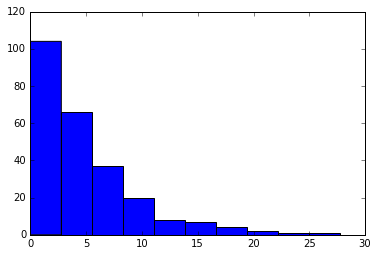

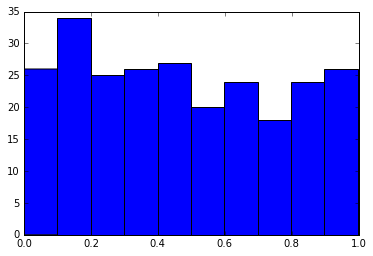

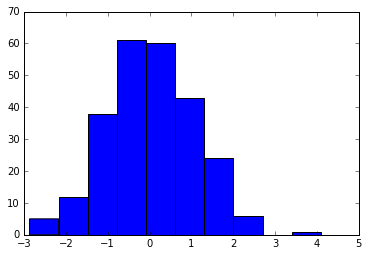

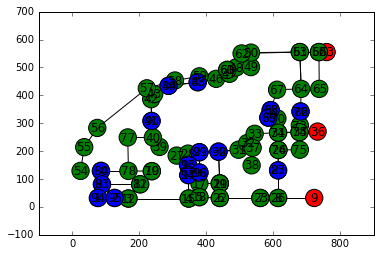

In [4]:
import csv
import math
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from copy import deepcopy
from heapq import heappush, heappop, heapify

#Process the input file and return the rows of split data.
def processInput(inputFile):
    rows = []
    with open(inputFile) as f:
        c = csv.reader(f, delimiter=',')
        for row in c:
            rows.append(row)

    return rows[1:]

#Binary search for node in a list of nodes
def findNode(nodes, node, i, j):
    end = node.end
    if((j-i) == 1):
        if(nodes[i].start == end or nodes[j].start == end):
            #Check for left
            while(i >= 0 and nodes[i].start == end):
                node.addChildNode(nodes[i])
                i -= 1
            while(j < len(nodes) and nodes[j].start == end):
                node.addChildNode(nodes[j])
                j += 1
    else:
        n = int(math.ceil((j-i)/2.0)) + i
        if(nodes[n].start <= end):
            findNode(nodes, node, n, j)
        else:
            findNode(nodes, node, i, n)

#Graphing function to show the node connections
def showGraph(nodes):
    nodes = deepcopy(nodes)
    nodes = sorted(nodes, key=lambda node: node.id)
    G=nx.Graph()
    colors = []
    for node in nodes:
        G.add_node(node.id, pos=node.end)
        children = node.getChildren()
        if(node.exit):
            colors.append(EXIT_NODE_COLOR)
        else:
            if(node.type == Node.TYPE_STREET):
                colors.append(STREET_NODE_COLOR)
            else:
                colors.append(PARKING_NODE_COLOR)
        for child in children:
            G.add_edge(node.id, child.id)
    pos=nx.get_node_attributes(G,'pos')
    pos=nx.spring_layout(G, pos=pos, fixed=pos.keys())
    plt.figure(4)
    nx.draw_networkx(G,pos,node_color=colors)
    plt.show()

#Init function that builds the world using the parsed rows
def buildGraph(rows):
    nodes = []
    i = 1
    for row in rows:
        assert(len(row) == 7)

        #Get node type, whether street or parking
        if(row[0] == 'Street'):
            nodeType = Node.TYPE_STREET
        elif(row[0] == 'Parking'):
            nodeType = Node.TYPE_PARKING
        else:
            raise Exception('Uknown type: ' + row[0])

        #Create node( type, (x1, x2), (y1, y2), capacity, id, comment)
        node = Node(nodeType, (int(row[1]), int(row[2])), (int(row[3]), int(row[4])), int(row[5]), i, comment=row[6])
        nodes.append(node)
        
        #Set evcuation destinations
        if(node.end == (760,555) or node.end == (723,32) or node.end == (733,270)):
            node.setExit(True)
        i += 1

        #Set initial cars in parking lotss
        if(nodeType == Node.TYPE_PARKING):
            for n in range(node.capacity):
                node.enterCar(Car(node))
    
    #Make node connections with its children.    
    nodes = sorted(nodes, key=lambda node: node.start)
    for node in nodes:
        findNode(nodes, node, 0, len(nodes) - 1)
    return nodes

def simulate():
    events = []
    #heappush (events, x_i)

def printDistribution():
    n = 250
    l = 5.0
    seed (20160224)
    e = [genRandom (l, type='exponential') for i in range (n)]
    u = [genRandom (l, type='uniform') for i in range (n)]
    g = [genRandom (l, type='normal') for i in range (n)]
    plt.figure(1)
    plt.hist (e)
    plt.show()
    plt.figure(2)
    plt.hist (u)
    plt.show()
    plt.figure(3)
    plt.hist (g)
    plt.show()

printDistribution()	
rows = processInput('world.csv')
nodes = buildGraph(rows)
showGraph(nodes)

## Priority queues

To maintain the future event list, you need some kind of priority queue data structure. One classical choice is to use a heap, for which there is a standard implementation in Python: [link](http://www.bogotobogo.com/python/python_PriorityQueue_heapq_Data_Structure.php)

Here's a quick demo.

In [5]:
from heapq import heappush, heappop, heapify

In [6]:
# Method 1: Convert any Python list into a heap
h1 = list (x_values)
print ("Initial values:", h1)

heapify (h1)
print ("\nHeapified:", h1)

print ("\nExtracting mins...")
for i in range (len (h1)):
    print (i, ":", heappop (h1))

('Initial values:', [4.2469217629189551, 13.295079509519617, 6.0324670983043145, 5.2788026272863497, 0.54812409637577308])
('\nHeapified:', [0.54812409637577308, 4.2469217629189551, 6.0324670983043145, 5.2788026272863497, 13.295079509519617])

Extracting mins...
(0, ':', 0.54812409637577308)
(1, ':', 4.2469217629189551)
(2, ':', 5.2788026272863497)
(3, ':', 6.0324670983043145)
(4, ':', 13.295079509519617)


In [7]:
# Method 2: Insert values into the heap one at a time

print ("Inserting...")
h2 = []
for (i, x_i) in enumerate (x_values):
    print (i, ":", x_i)
    heappush (h2, x_i)
    
print ("\nHeap:", h2)
    
print ("\nExtracting minima...")
for i in range (len (h2)):
    print (i, ":", heappop (h2))

Inserting...
(0, ':', 4.2469217629189551)
(1, ':', 13.295079509519617)
(2, ':', 6.0324670983043145)
(3, ':', 5.2788026272863497)
(4, ':', 0.54812409637577308)
('\nHeap:', [0.54812409637577308, 4.2469217629189551, 6.0324670983043145, 13.295079509519617, 5.2788026272863497])

Extracting minima...
(0, ':', 0.54812409637577308)
(1, ':', 4.2469217629189551)
(2, ':', 5.2788026272863497)
(3, ':', 6.0324670983043145)
(4, ':', 13.295079509519617)


## A generic discrete event simulation engine

We can build a simple, generic discrete event simulation engine. This engine manages the future event list, which you'll recall is a priority queue of timestamped events. It continually removes the event with the lowest timestamp and processes it.

Suppose we represent an event by a tuple, `(t, e)`, where `t` is the event's timestamp and `e` is an event handler. An event handler is simply a function. Let's suppose that this function takes two arguments, `e (t, s)`, where `t` is (again) the timestamp and `s` is the system state, encoded in an application-specific way. When `e (t, s)` executes, it may update the state `s`.

**Exercise.** Complete the following function, which implements a generic discrete event simulation engine. The future events list is `events`. The initial system state is `initial_state`; the starter code below makes a copy of this state as a variable `s`, which your simulator can modify. Additionally, you should correct the last `print()` statement so that instead of a pair of `None` values it prints the timestamp and event name (name of the event handler).

In [8]:
from copy import deepcopy

def simulate (events, initial_state):
    s = deepcopy (initial_state)
    
    print ("\nFuture event list:\n%s" % str (events))
    print ("\nt=0: %s" % str (s))
        
    while events:
        # @YOUSE: Get event and process it
        (t, e) = heappop(events)
        e(t, s)
        
        print ("t=%d: event '%s' => '%s'" % (t, e, str (s)))

## Instantiating the simulator

For the gas station model, we asked you to assume the interarrival times, pumping times, and shopping times were exponential i.i.d. random variables. So, let's start by defining some parameters for these distributions. Let's also pre-generate some number of car arrivals.

In [16]:
# Event parameters
MEAN_INTERARRIVAL_TIME = 15.0 # minutes
MEAN_PUMPING_TIME = 5.0 # minutes
MEAN_SHOPPING_TIME = 10.0 # minutes

# Number of customers (cars)
NUM_CARS = 5

# Pre-generate some interarrival times
car_interarrival_times = exponential (MEAN_INTERARRIVAL_TIME, NUM_CARS)
print ("Interrival times (in minutes) of all cars:\n", car_interarrival_times)

('Interrival times (in minutes) of all cars:\n', array([  8.33243896,   1.52429913,   2.81272745,  29.66129514,   3.04412049]))


Recall that the state consists of the logical simulation time (`now`) and three state variables: `AtPump`, `AtStore`, and `PumpFree`. Let's create this state.

In [17]:
now = 0.0 # Current (logical) simulation time
state = {'AtPump': 0          # no. cars at pump or waiting
         , 'AtStore': 0       # no. cars at store
         , 'PumpFree': True   # True <==> pump is available
        }

Let's represent an _event_ as a tuple, `(t, e)`, where `t` is the timestamp of the event and `e` is an event handler, implemented as a Python function.

If the future event list is stored in a global priority queue called `events`, the following function will insert an event into that queue.

In [18]:
def schedule (t, e):
    """
    Schedules a new event `e` at time `t`.
    """
    global events
    print ("  ==> '%s' @ t=%g" % (e.__name__, t))
    heappush (events, (t, e))

**Exercise.** Implement an event handler to process a car arrival event. Assume that event handlers take as input the timestamp `t` of the event and the state `s` of the system at time `t`.

In [19]:
def arrives (t, s):
    """
    Processes an arrival event at time `t` for a system in state `s`.
    Schedules a pumping event if the pump is free. Returns the new
    system state.
    """
    # @YOUSE
    s['AtPump'] += 1
    if s['PumpFree']:
        s['PumpFree'] = False
        t_done = t + exponential (MEAN_PUMPING_TIME)
        schedule(t_done, finishes)
    return s

**Exercise.** Implement a function to process the event for a car that finishes pumping gas.

In [20]:
def finishes (t, s):
    """
    Processes a finished-pumping event at time `t` for a system in
    state `s`. Schedules a pumping event if any cars are waiting.
    Returns the new system state.
    """
    # @YOUSE
    s['AtPump'] -= 1
    if s['AtPump'] > 0:
        #Schedule
        schedule (t + exponential (MEAN_PUMPING_TIME), finishes)
    else:
        s['PumpFree'] = True
    s['AtStore'] += 1
    schedule (t + exponential (MEAN_SHOPPING_TIME), departs)
    return s

**Exercise.** Implement a function to process the event for a car that leaves the store.

In [21]:
def departs (t, s):
    """
    Processes a departure from the station event at
    time `t` for a system in state `s`.
    """
    # @YOUSE
    s['AtStore'] -= 1
    return s

**Exercise.** Create an initial future events list by converting the raw interarrival times into arrival events and inserting them into the future events list.

In [22]:
# Hint: This function may prove useful
from numpy import cumsum

events = []  # Future event list, initially empty

# @YOUSE: Create initial events from all car arrivals
for i in range(NUM_CARS):
    schedule(car_interarrival_times[i],arrives)

# Test code
print ("\nContents of `events[:]`:")
for (i, event) in enumerate (events):
    print ("[%d] t=%g: %s" % (i, event[0], event[1].__name__))

  ==> 'arrives' @ t=8.33244
  ==> 'arrives' @ t=1.5243
  ==> 'arrives' @ t=2.81273
  ==> 'arrives' @ t=29.6613
  ==> 'arrives' @ t=3.04412

Contents of `events[:]`:
[0] t=1.5243: arrives
[1] t=3.04412: arrives
[2] t=2.81273: arrives
[3] t=29.6613: arrives
[4] t=8.33244: arrives


In [23]:
# More test code: If everything worked, so should this simulation!
simulate (events, state)


Future event list:
[(1.5242991332787799, <function arrives at 0x0000000002670EB8>), (3.0441204883571267, <function arrives at 0x0000000002670EB8>), (2.8127274452089295, <function arrives at 0x0000000002670EB8>), (29.66129513916097, <function arrives at 0x0000000002670EB8>), (8.3324389625676911, <function arrives at 0x0000000002670EB8>)]

t=0: {'PumpFree': True, 'AtStore': 0, 'AtPump': 0}
  ==> 'finishes' @ t=5.2014
t=1: event '<function arrives at 0x0000000002670EB8>' => '{'PumpFree': False, 'AtStore': 0, 'AtPump': 1}'
t=2: event '<function arrives at 0x0000000002670EB8>' => '{'PumpFree': False, 'AtStore': 0, 'AtPump': 2}'
t=3: event '<function arrives at 0x0000000002670EB8>' => '{'PumpFree': False, 'AtStore': 0, 'AtPump': 3}'
  ==> 'finishes' @ t=9.7251
  ==> 'departs' @ t=6.69922
t=5: event '<function finishes at 0x00000000026BD2E8>' => '{'PumpFree': False, 'AtStore': 1, 'AtPump': 2}'
t=6: event '<function departs at 0x00000000026BD278>' => '{'PumpFree': False, 'AtStore': 0, 'AtPump